In [5]:
import jax.numpy as jnp
import jax.random as jrandom

import matplotlib.pyplot as plt
import pandas as pd
from jax import jit, grad, jacfwd, jacrev

import pycutest

import scipy 

from scipy.stats import linregress

from tqdm import tqdm
import pickle

import numpy as np

from tqdm import tqdm

from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [12,12]
plt.style.use('ggplot')
plt.rcParams['lines.markersize'] = 8
plt.rcParams.update({'font.size': 12})

%load_ext autoreload
%autoreload 2

import time

In [33]:
import sys
sys.path.append("..")
from Functions import PyCutestWrapper
from USimplex import USD
# from optimize_USG_error import create_S
sys.path.append("../OptimalSetComps")
from custom import create_S
from AdaptiveFD import adapt_FD
from optimize_USG_error import get_lambda_star, loss_getter, get_alpha, get_V_star, get_lambda_tilde
from create_W import optimize_W, convert_to_U, generate_regular_simplex
from efficient_sampling_set import create_approx_S

In [70]:


def helper_linesearch(f, g, c1, c2):

    def helper(X, search_direction):
        f0 = f(X)
        f1 = g(X)
        dg = jnp.inner(search_direction, f1)

        def armijo_rule(alpha):
            return f(X + alpha * search_direction) > f0 + c1*alpha*dg
        
        def armijo_update(alpha):
            return c2*alpha
            
        alpha = 1
        while armijo_rule(alpha):
            alpha = armijo_update(alpha)


        return alpha

    return helper


def loss_getter(dim, N, H, sig, coeff):
    def helper(X):

        S = X.reshape(N, dim).T
        
        S_inv = jnp.linalg.inv(S)
        
        first_term = S_inv.T @ jnp.diag(S.T @ H @ S)
        second_term = jnp.linalg.norm(S_inv, ord="fro")**2
        third_term = S_inv.T @ jnp.ones(dim)
        third_term = jnp.linalg.norm(third_term)**2
        return 1/2 * jnp.linalg.norm(first_term)**2 + sig**2 * (second_term + third_term) + coeff*jnp.linalg.norm(S)**4

    return helper

def optimize_uncentered_S(H, sig, coeff, max_steps=15, jrandom_key=None, x_curr=None):
    
    dim = H.shape[0]
    N = dim
    
    H = (H + H.T) / 2. # to combat numerical inaccuracies. 
    D, U = jnp.linalg.eig(H)
    U = jnp.real(U)

    # print("D", repr(jnp.real(D)))
#     D = jnp.abs(jnp.real(jnp.diag(D)))
    D = jnp.diag(D)

    if x_curr is None:

        if jrandom_key is None:
            x_curr = jnp.diag(jnp.sqrt(sig / jnp.abs(jnp.diag(D)))).flatten()
            pass
        else:
            x_curr = jrandom.normal(jrandom_key, shape=(dim * dim,)) * 0.1
        

    
    l = loss_getter(dim, N, D, sig, coeff)
    g_l = grad(l)
    h_l = jacfwd(g_l)
    linesearch = helper_linesearch(l, g_l, c1=0.1, c2=0.9)

    eps = 1e-20

    res = []
    res_x = []

    for t in tqdm(range(max_steps)):

        
        res.append(l(x_curr))
#         res_x.append(U.dot(x_curr.reshape(N, dim).T)) # TURN ON FOR HISTORY 

        curr_grad = g_l(x_curr)
#         print(curr_grad)
    
        # print(curr_grad)
#         curr_hess = h_l(x_curr) #+ .1*jnp.eye(dim**2)
#         search_direction = -jnp.linalg.inv(curr_hess) @ curr_grad #+ np.random.normal(size=(dim**2))*0.1
        search_direction = -curr_grad + np.random.normal(size=(dim * dim))*0.1

        if jnp.linalg.norm(curr_grad) < eps:
            break    

        alpha = linesearch(x_curr, search_direction)


        S = x_curr.reshape(N, dim).T

        SS = S.dot(S.T)

        x_curr += alpha*search_direction 
    
    return U.dot(x_curr.reshape(N, dim).T), res

In [80]:
jrandom_key = jrandom.PRNGKey(0)

dim = 100
# D = jnp.diag(jnp.array([1, 1, 1, 1, 100, 100]))
D = jnp.diag(jnp.logspace(-2, 2, dim))
# D = jnp.diag(jnp.real(jnp.array([ 6.96867074e+03+0.j, -5.65090364e+03+0.j,
#               3.30117392e+01+0.j,  8.67518225e+00+0.j,
#              -3.02376833e+00+0.j])))

# D = jnp.diag(jnp.array([1e6, 1e3, -1, -100, -200]))
sig = 0.1
coeff = 0.1

l = loss_getter(dim, dim, D, sig, coeff)



In [93]:
a = time.time()
S_approx = create_approx_S(D, sig, coeff, jrandom_key)
print(time.time() - a)

Get pow sets 0.005705833435058594
Get S 1.9073486328125e-06
Get S 7.152557373046875e-07
Sing vals gets 0.09520101547241211
Get S 0.09561419486999512
Get S 9.5367431640625e-07
Get S 9.5367431640625e-07
Sing vals gets 2.406231164932251
Get S 2.406792402267456
Sing vals gets 3.834458112716675
Get S 3.8349881172180176
6.345219135284424


In [82]:
l(S_approx.T.flatten())

DeviceArray(78.40467099, dtype=float64)

In [89]:
a = time.time()
S, _ = create_S(D, sig, num_iter=50, x_init=None, coeff=coeff)
print(time.time() - a)

4.306080102920532


In [86]:
l(S.T.flatten())

DeviceArray(167.08155549, dtype=float64)

In [987]:
grad(l)(S.T.flatten())

DeviceArray([-2.34537929,  0.00630642, -0.01190244, -0.05425252,
             -2.34537927, -0.00630642,  0.01190244, -0.05425252,
              2.34538028, -0.00630643, -0.01190244, -0.05425253,
              2.34538032,  0.00630643,  0.01190244, -0.05425253],            dtype=float64)

In [988]:
S

DeviceArray([[-0.01397491, -0.01397491,  0.01397491,  0.01397491],
             [ 0.07670271, -0.07670271, -0.07670271,  0.07670271],
             [-0.14124202,  0.14124202, -0.14124202,  0.14124202],
             [ 1.41784695,  1.41784695,  1.41784695,  1.41784695]],            dtype=float64)

In [83]:
jrandom_key, subkey = jrandom.split(jrandom_key)
opt_S, l_hist = optimize_uncentered_S(D, sig=sig, coeff=coeff, max_steps=50, jrandom_key=subkey, x_curr=None)



100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


In [84]:
l(opt_S.T.flatten())

DeviceArray(1931.17895715, dtype=float64)

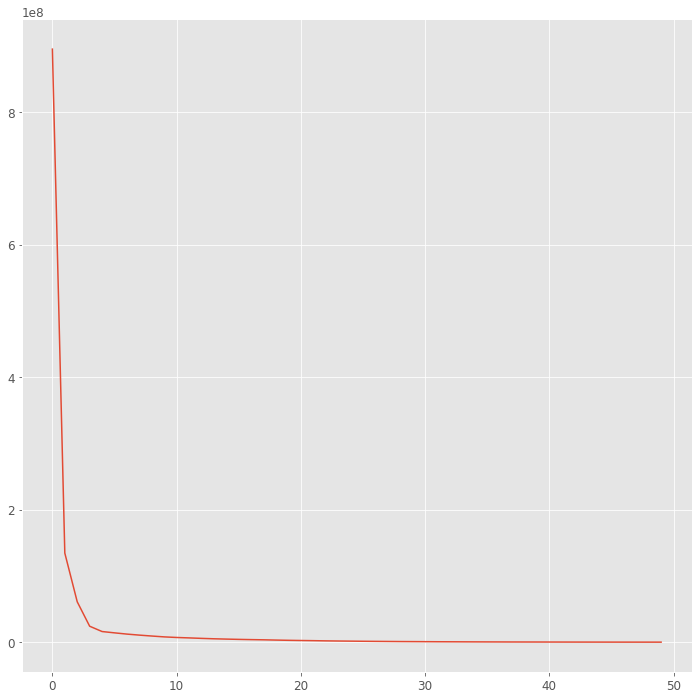

In [73]:
plt.plot(l_hist)
plt.show()

In [672]:
def loss_getter(dim, N, H, sig, coeff):
    def helper(X):

        S = X.reshape(N, dim).T
        
        S_inv = jnp.linalg.inv(S)
        
        first_term = S_inv.T @ jnp.diag(S.T @ H @ S)
        second_term = jnp.linalg.norm(S_inv, ord="fro")**2
        third_term = S_inv.T @ jnp.ones(dim)
        third_term = jnp.linalg.norm(third_term)**2
        return 1/2 * jnp.linalg.norm(first_term)**2 + sig**2 * (second_term + third_term) + coeff*jnp.linalg.norm(S)**4

    return helper

l = loss_getter(dim, dim, D, sig, coeff)
l(S.T.flatten())

DeviceArray(1053.32800332, dtype=float64)

In [691]:

lmbda_star = get_lambda_star(dim, sig, coeff)
a = jnp.diag(D) @ lmbda_star / len(lmbda_star)
a

DeviceArray(113.24176376, dtype=float64)

In [981]:
def lmbda_loss(lmbdas, dim, D, sig, coeff):
    a = D @ lmbdas / len(lmbdas)
    b = jnp.sum(lmbdas)
    return 1/2 * a**2 * dim / lmbdas[0] + sig**2 * dim/lmbdas[0] + sig**2 * jnp.sum(1/lmbdas) + coeff*b**2


lmbda_tilde = get_lambda_tilde(jnp.diag(D)[::-1], sig, coeff, get_lambda_star(dim, sig, coeff))

lmbda_loss(lmbda_tilde, dim, jnp.diag(D)[::-1], sig, coeff)

DeviceArray(0.44972964, dtype=float64)

In [965]:
S, _ = create_S(D, sig, num_iter=50, x_init=None, coeff=coeff)
l(S.T.flatten())

1.2602328261483324e-11
1.2602328261483324e-11


DeviceArray(9.39468455e+08, dtype=float64)

In [967]:
S

DeviceArray([[-0.13665095, -0.13665095,  0.13665095,  0.13665095],
             [ 0.22476864, -0.22476864, -0.22476864,  0.22476864],
             [-0.22512494,  0.22512494, -0.22512494,  0.22512494],
             [ 0.43152831,  0.43152831,  0.43152831,  0.43152831]],            dtype=float64)

In [966]:
grad(l)(S.T.flatten())

DeviceArray([-6.86324443e+09,  1.12889235e+07,  1.13068181e+04,
             -1.09070363e+09, -6.86324443e+09, -1.12889235e+07,
             -1.13068181e+04, -1.09070363e+09,  6.86324443e+09,
             -1.12889235e+07,  1.13068181e+04, -1.09070363e+09,
              6.86324443e+09,  1.12889235e+07, -1.13068181e+04,
             -1.09070363e+09], dtype=float64)

In [471]:
S, _ = create_S(D, sig, num_iter=50, x_init=None, coeff=coeff)
l(S.T.flatten())

[[ 0.99962264  0.00353113  0.0272416 ]
 [-0.00369661  0.99997501  0.00602662]
 [-0.02721964 -0.00612505  0.99961071]]
39.08299683867193
36.59666940787413
35.48337163293935
34.67968617730389
34.37915913644767
34.22864623740312
34.14449242158221
34.09475442998261
34.06442613626818
34.04558803513825
34.033754037871454
34.02626758248531
34.021510521301074
34.018479318359965
34.0165443993508
34.01530787615656
34.01395561482384
34.013435890216904
34.0132360447869
34.013159185700516
34.01312962416445
34.01311825389871
34.01311388050289
34.0131121983374
34.01311155131507
34.01311130244642
34.01311120672235
34.01311116990335
34.01311115574138
34.013111150294165
34.01311114819898
34.013111147393076
34.0131111470831
34.013111146963865
34.01311114691801
34.01311114690039
34.01311114689639
34.013111146892044
34.01311114689039
34.01311114688976
34.013111146889514
34.01311114688945
34.01311114688939
34.013111146889365
34.01311114688936
34.01311114688934
34.01311114688934
34.01311114688934
34.01311114

DeviceArray(5088.14390058, dtype=float64)

In [308]:
baseline_res = []
costum_res = []

for n in np.linspace(2, 50, 5):
    start_time = time.time()
    opt_S, _ = optimize_uncentered_S(D, sig=sig, coeff=coeff, max_steps=2*int(n), jrandom_key=jrandom_key, x_curr=None)
    baseline_res.append([l(opt_S.T.flatten()), time.time() - start_time])
    
    
    start_time = time.time()    
    S, _ = create_S(D, sig, num_iter=int(n), x_init=None, coeff=coeff)
    costum_res.append([l(S.T.flatten()), time.time() - start_time])



  4%|██▋                                                                    | 2/52 [00:00<00:13,  3.68it/s]

KeyboardInterrupt



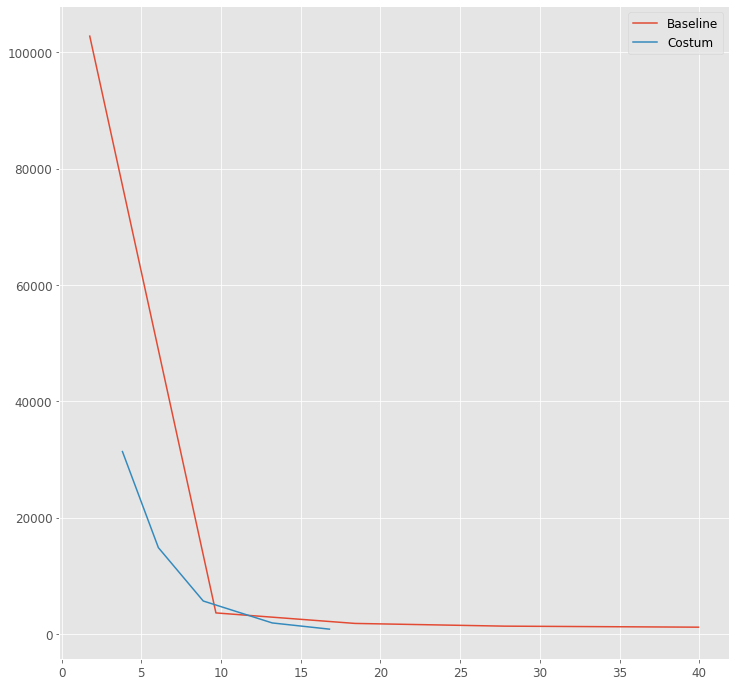

In [291]:
baseline_res = jnp.array(baseline_res)
custom_res = jnp.array(costum_res)

plt.plot(baseline_res[:, 1], baseline_res[:, 0], label="Baseline")
plt.plot(custom_res[:, 1], custom_res[:, 0], label="Costum")
plt.legend()
plt.show()